# SPARQL wrapper

We use a lightweight wrapper to make it possible to query ApertureDB in the RDF/SPARQL query language.  This wrapper makes it easy for users already familiar with the SPARQL query language to compose queries against an ApertureDB instance.

Note that SPARQL queries will be neither as powerful nor (necessarily) as efficient as writing queries in the [ApertureDB Query Language](https://docs.aperturedata.io/category/aperturedb-query-language)

In [1]:
%pip uninstall -y aperturedb
%pip install --quiet --upgrade git+https://github.com/aperture-data/aperturedb-python@sparql-query rdflib

Found existing installation: aperturedb 0.4.34
Uninstalling aperturedb-0.4.34:
  Successfully uninstalled aperturedb-0.4.34
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# We're going to use the pandas library to display binding sets in a more readable format.
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 50)

## Create SPARQL wrapper object

In [3]:
from aperturedb.SPARQL import SPARQL
import json

# Create SPARQL object. We'll use the debugging feature to print interesting information.
sparql = SPARQL(debug=True)

This wrapper object has a connection to an ApertureDB instance.
It downloads the schema on creation, and sets up:
* Turtle namespaces
* A mapping from property URIs to the ApertureDB object types that use them
* A mapping from connection URIs to the ApertureDB objects that can be source and destination

Namespaces are just a shorthand used in certain RDF serializations to make URLs shorter.
Note that the namespace `p:` can be used for ApertureDB property names, and `c:` for ApertureDB connection classes.

In [4]:

print("namespaces:", json.dumps({k: str(v) for k, v in sparql.namespaces.items()}, indent=2))


namespaces: {
  "t": "http://aperturedb.io/type/",
  "c": "http://aperturedb.io/connection/",
  "p": "http://aperturedb.io/property/",
  "o": "http://aperturedb.io/object/",
  "knn": "http://aperturedb.io/knn/",
  "Ingredient": "http://aperturedb.io/object/Ingredient/",
  "_Descriptor": "http://aperturedb.io/object/_Descriptor/",
  "_DescriptorSet": "http://aperturedb.io/object/_DescriptorSet/",
  "_Image": "http://aperturedb.io/object/_Image/"
}


In [5]:
print("properties:", json.dumps({sparql.graph.qname(k): str(v)
      for k, v in sparql.properties.items()}, indent=2))


properties: {
  "p:UUID": "{'Ingredient'}",
  "p:category": "{'Ingredient'}",
  "p:macronutrient": "{'Ingredient'}",
  "p:micronutrient": "{'Ingredient'}",
  "p:name": "{'Ingredient', '_Image'}",
  "p:other_names": "{'Ingredient'}",
  "p:subgroup": "{'Ingredient'}",
  "p:_label": "{'_Descriptor'}",
  "p:_dimensions": "{'_DescriptorSet'}",
  "p:_name": "{'_DescriptorSet'}",
  "p:Recipe%20URL": "{'_Image'}",
  "p:adb_data_source": "{'_Image'}",
  "p:adb_image_height": "{'_Image'}",
  "p:adb_image_id": "{'_Image'}",
  "p:adb_image_sha256": "{'_Image'}",
  "p:adb_image_size": "{'_Image'}",
  "p:adb_image_width": "{'_Image'}",
  "p:caption": "{'_Image'}",
  "p:contributor": "{'_Image'}",
  "p:cuisine": "{'_Image'}",
  "p:id": "{'_Image'}",
  "p:location": "{'_Image'}",
  "p:type": "{'_Image'}"
}


In [6]:
print("connections:", json.dumps({sparql.graph.qname(k): str(v)
      for k, v in sparql.connections.items()}, indent=2))

connections: {
  "c:HasIngredient": "({'_Image'}, {'Ingredient'})",
  "c:_DescriptorConnection": "({'_Descriptor'}, {'_Image'})",
  "c:_DescriptorSetToDescriptor": "({'_DescriptorSet'}, {'_Descriptor'})"
}


## Create query and run it

In [7]:
# Find all images with chicken and butter as ingredients
query1 = """
SELECT ?s ?caption {
?s c:HasIngredient [p:name "chicken"] , [p:name "butter"] ;
    p:caption ?caption .
} LIMIT 10
"""

# Find all images with chicken or butter as ingredients
query2 = """
SELECT ?s ?caption WHERE {
VALUES ?ingredient { "chicken" "butter" }
?s c:HasIngredient [p:name ?ingredient] ;
    p:caption ?caption .
} LIMIT 10
"""

# Find the top 10 ingredients
query3 = """
SELECT (COUNT(*) AS ?count) ?ingredient WHERE {
?s c:HasIngredient [p:name ?ingredient] .
} GROUP BY ?ingredient ORDER BY DESC(?count) LIMIT 10
"""

query = query1

print(query)


SELECT ?s ?caption {
?s c:HasIngredient [p:name "chicken"] , [p:name "butter"] ;
    p:caption ?caption .
} LIMIT 10



In [8]:
df = sparql.to_dataframe(sparql.query(query))
print(df)

                s                                            caption
0  _Image:7.3.200               Chicken in Creamy tomato based gravy
1  _Image:7.7.280  Butter chicken, special fried rice, garlic naa...


RDF/SPARQL is a text-based language and does not handle blobs.  The wrapper provides some utility methods `get_blob`, `get_image`, and `show_image` to handle images.  Currently these fetched from ApertureDB in a separate query, but caching or batching would also be possible.

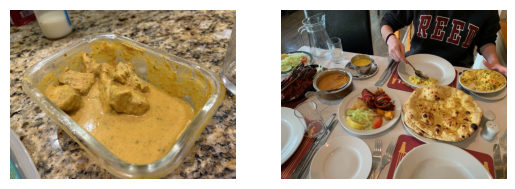

In [9]:
sparql.show_images(df.s)

Under the covers, rdflib will parse the query and turn it into flattened triples.  Blank nodes get special identifiers.

In [10]:
print(sparql._format_triples(sparql.triples))

N3350eefcceed4944a4ed5fc63df7e480 p:name butter .
Nc5e0a0254a4e4618b4c170faa11e08b8 p:name chicken .
?s c:HasIngredient N3350eefcceed4944a4ed5fc63df7e480 .
?s c:HasIngredient Nc5e0a0254a4e4618b4c170faa11e08b8 .
?s p:caption ?caption


When the wrapper is passed these triples, it converts them into an ApertureDB query.

In [11]:
print(json.dumps(sparql.input_query, indent=2))

[
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "_ref": 1,
      "uniqueids": true,
      "constraints": {
        "name": [
          "==",
          "butter"
        ]
      }
    }
  },
  {
    "FindEntity": {
      "with_class": "Ingredient",
      "_ref": 2,
      "uniqueids": true,
      "constraints": {
        "name": [
          "==",
          "chicken"
        ]
      }
    }
  },
  {
    "FindImage": {
      "_ref": 3,
      "uniqueids": true,
      "is_connected_to": {
        "all": [
          {
            "ref": 1,
            "direction": "in",
            "connection_class": "HasIngredient"
          },
          {
            "ref": 2,
            "direction": "in",
            "connection_class": "HasIngredient"
          }
        ]
      },
      "group_by_source": true,
      "results": {
        "list": [
          "caption"
        ]
      }
    }
  }
]


It run the query and gets a response.

In [12]:
print(json.dumps(sparql.output_response, indent=2))

[
  {
    "FindEntity": {
      "entities": [
        {
          "_uniqueid": "8.11.980"
        }
      ],
      "returned": 1,
      "status": 0
    }
  },
  {
    "FindEntity": {
      "entities": [
        {
          "_uniqueid": "8.14.1040"
        }
      ],
      "returned": 1,
      "status": 0
    }
  },
  {
    "FindImage": {
      "entities": {
        "8.11.980": [
          {
            "_uniqueid": "7.3.200",
            "caption": "Chicken in Creamy tomato based gravy"
          },
          {
            "_uniqueid": "7.7.280",
            "caption": "Butter chicken, special fried rice, garlic naan, peshwari naan"
          }
        ],
        "8.14.1040": [
          {
            "_uniqueid": "7.3.200",
            "caption": "Chicken in Creamy tomato based gravy"
          },
          {
            "_uniqueid": "7.7.280",
            "caption": "Butter chicken, special fried rice, garlic naan, peshwari naan"
          }
        ]
      },
      "group_by_source"

We then convert the query response into a set of solutions, each of which is a mapping of variables to values.

In [13]:
solutions = [ {str(k): sparql._format_node(v) for k, v in solution.items()} for solution in sparql.solutions ]
print(len(solutions))
for solution in solutions:
    print(solution)

2
{'s': '_Image:7.7.280', 'caption': 'Butter chicken, special fried rice, garlic naan, peshwari naan'}
{'s': '_Image:7.3.200', 'caption': 'Chicken in Creamy tomato based gravy'}


## KNN search

Doing descriptor search requires something like the following:

```python
?descriptor knn:search [
    knn:vector "[1,2,3,4,5]" ;   # vector for descriptor as a JSON string
    knn:set "RecipeEmbeddings" ; # descriptor set
    knn:k_neighbors 5 ;          # number of results
    knn:knn_first true ;         # optional
    knn:engine "HNSW" ;          # optional
    knn:metric "L2" ;            # optional
    knn:distance ?distance       # optional, binds to distance literals
] .
```

Here we bind `?descriptor` to a knn search specification.  

In [14]:
import numpy as np
descriptor = np.random.rand(512)

query = f"""
SELECT ?i ?distance ?d ?caption WHERE {{
?d knn:similarTo [ 
    knn:set 'ViT-B/16' ; 
    knn:k_neighbors 20 ;
    knn:vector "{sparql.encode_descriptor(descriptor)}" ;
    knn:distance ?distance 
] ;
    c:ANY ?i . # Use fake connection because we can't say c:_DescriptorConnection
    ?i p:caption ?caption . 
}}
"""
print(query)


SELECT ?i ?distance ?d ?caption WHERE {
?d knn:similarTo [ 
    knn:set 'ViT-B/16' ; 
    knn:k_neighbors 20 ;
    knn:vector "[0.9555488882638771, 0.12408691380868142, 0.7121739691831184, 0.09706649503562248, 0.15139082764491774, 0.13895819114263064, 0.7702894662441396, 0.7660664034195827, 0.6795734845861371, 0.34490060588874527, 0.6163611508948792, 0.37257972535678774, 0.28291631331202527, 0.2629969993252992, 0.286297608600668, 0.17387890071500078, 0.9693074951571263, 0.7370553358643565, 0.2677427962331298, 0.10059891222196271, 0.7426690575344832, 0.478636053178653, 0.32584476308475696, 0.6716872809163725, 0.8793102454457253, 0.5097939417612015, 0.11216747629135604, 0.5071777767298513, 0.3666023866971181, 0.2247221545386845, 0.39253332426483867, 0.6819170777015081, 0.80605196094182, 0.47035768436399883, 0.5699052869926331, 0.8844116676996001, 0.6212615656390592, 0.48713272633362004, 0.9340958917239872, 0.4978733024320038, 0.7831660453548225, 0.09048706410906171, 0.7766215206729598, 

In [15]:
df = sparql.to_dataframe(sparql.query(query))
print(df)

                  i    distance                     d                                            caption
0    _Image:7.5.240  240.854279   _Descriptor:3.5.240  Baked potato with Scottish Cheddar, Branston P...
1   _Image:7.25.640  242.569336  _Descriptor:3.25.640     Fresh homemade tortillas with egg and tomatoes
2    _Image:7.7.280  245.076050   _Descriptor:3.7.280  Butter chicken, special fried rice, garlic naa...
3   _Image:7.22.580  245.469254  _Descriptor:3.22.580           Buttery croissants with chocolate inside
4    _Image:7.3.200  246.823120   _Descriptor:3.3.200               Chicken in Creamy tomato based gravy
5   _Image:7.15.440  247.937042  _Descriptor:3.15.440                                salmon, white beans
6   _Image:7.18.500  248.319458  _Descriptor:3.18.500                                   waffle, smoothie
7   _Image:7.29.720  251.166656  _Descriptor:3.29.720  Waffles with whipped cream, chocolate and stra...
8    _Image:7.0.140  251.503464   _Descriptor:3.0.140  

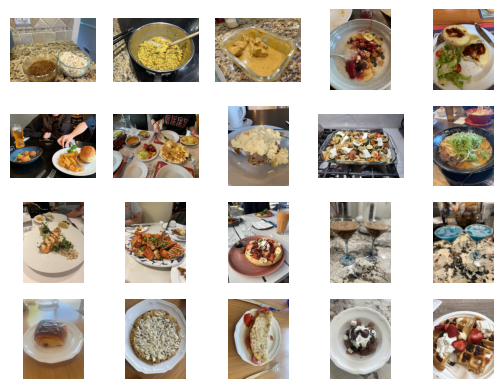

In [16]:
sparql.show_images(df.i)